In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, \
                            recall_score, f1_score, log_loss

from tqdm.notebook import tqdm

RAND = 42

In [2]:
db = pd.read_parquet(
    "/home/sergey/projects/Credit_scoring/raw/train_data/train_data_0.pq", 
    engine="pyarrow"
)

In [3]:
def get_bins_target(df: pd.DataFrame, target_name: str) -> None:
    # нормирование на размер датасета
    norm_target = (df[target_name].value_counts(
        normalize=True).mul(100).rename('percent').reset_index())

    plt.figure(figsize=(15, 7))
    ax = sns.barplot(x='index', y='percent', data=norm_target)

    # Вывод значений над графиками - annotate()
    # В цикле смотрим каждый столбец графика и на нем отмечаем значения
    for p in ax.patches:
        percentage = '{:.1f}%'.format(p.get_height())
        ax.annotate(
            percentage,  # текст
            # координата xy
            (p.get_x() + p.get_width() / 2., p.get_height()),
            # центрирование
            ha='center',
            va='center',
            xytext=(0, 10),
            # точка смещения относительно координаты
            textcoords='offset points',
            fontsize=14)

    plt.title(target_name, fontsize=20)
    plt.xlabel(target_name, fontsize=14)
    plt.ylabel('Проценты', fontsize=14)

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()

In [27]:
def get_metrics(y_test, y_pred, y_score, name = "Default"):
    """Метрики для задачи классификации"""
    df_metrics = pd.DataFrame()

    df_metrics['model'] = [name]
    df_metrics['Accuracy'] = accuracy_score(y_test, y_pred)
    df_metrics['ROC_AUC'] = roc_auc_score(y_test, y_score[:, 1])
    df_metrics['Precision'] = precision_score(y_test, y_pred)
    df_metrics['Recall'] = recall_score(y_test, y_pred)
    df_metrics['f1'] = f1_score(y_test, y_pred)
    df_metrics['Logloss'] = log_loss(y_test, y_score)

    return df_metrics

In [3]:
db[:5]

,id,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
0,0,1,18,9,2,3,16,10,11,3,...,3,3,3,4,1,3,4,1,0,0
1,0,2,18,9,14,14,12,12,0,3,...,0,0,0,4,1,3,4,1,0,0
2,0,3,18,9,4,8,1,11,11,0,...,0,0,0,4,1,2,3,1,1,1
3,0,4,4,1,9,12,16,7,12,2,...,3,3,3,4,1,3,1,1,0,0
4,0,5,5,12,15,2,11,12,10,2,...,3,3,3,4,1,3,4,1,0,0


In [4]:
db = db.set_index(["id", "rn"])

In [6]:
db.isna().sum()

pre_since_opened                 0
pre_since_confirmed              0
pre_pterm                        0
pre_fterm                        0
pre_till_pclose                  0
pre_till_fclose                  0
pre_loans_credit_limit           0
pre_loans_next_pay_summ          0
pre_loans_outstanding            0
pre_loans_total_overdue          0
pre_loans_max_overdue_sum        0
pre_loans_credit_cost_rate       0
pre_loans5                       0
pre_loans530                     0
pre_loans3060                    0
pre_loans6090                    0
pre_loans90                      0
is_zero_loans5                   0
is_zero_loans530                 0
is_zero_loans3060                0
is_zero_loans6090                0
is_zero_loans90                  0
pre_util                         0
pre_over2limit                   0
pre_maxover2limit                0
is_zero_util                     0
is_zero_over2limit               0
is_zero_maxover2limit            0
enc_paym_0          

In [5]:
db.shape

(1974724, 59)

In [8]:
db.describe().iloc[1:, :]

,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,pre_loans_total_overdue,...,enc_paym_21,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag
mean,9.271325,8.330264,8.299071,8.309444,6.991781,8.337011,9.740888,2.399848,3.012951,0.0,...,2.313242,2.343014,2.376717,3.576724,1.027562,2.694898,3.353936,1.002386,0.172138,0.223934
std,5.773757,4.593511,5.245598,4.464844,5.184165,4.233992,5.799625,1.376391,0.683844,0.0,...,1.247674,1.228473,1.205555,1.035586,0.276702,0.489136,1.057304,0.059093,0.377501,0.416878
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.000000,5.000000,4.000000,6.000000,1.000000,5.000000,5.000000,2.000000,3.000000,0.0,...,3.000000,3.000000,3.000000,4.000000,1.000000,2.000000,3.000000,1.000000,0.000000,0.000000
50%,9.000000,9.000000,8.000000,8.000000,6.000000,10.000000,10.000000,2.000000,3.000000,0.0,...,3.000000,3.000000,3.000000,4.000000,1.000000,3.000000,4.000000,1.000000,0.000000,0.000000
75%,14.000000,11.000000,13.000000,12.000000,12.000000,11.000000,15.000000,2.000000,3.000000,0.0,...,3.000000,3.000000,3.000000,4.000000,1.000000,3.000000,4.000000,1.000000,0.000000,0.000000
max,19.000000,17.000000,17.000000,16.000000,16.000000,15.000000,19.000000,6.000000,5.000000,0.0,...,3.000000,3.000000,3.000000,4.000000,6.000000,6.000000,5.000000,3.000000,1.000000,1.000000


In [6]:
db.columns

Index(['pre_since_opened', 'pre_since_confirmed', 'pre_pterm', 'pre_fterm',
       'pre_till_pclose', 'pre_till_fclose', 'pre_loans_credit_limit',
       'pre_loans_next_pay_summ', 'pre_loans_outstanding',
       'pre_loans_total_overdue', 'pre_loans_max_overdue_sum',
       'pre_loans_credit_cost_rate', 'pre_loans5', 'pre_loans530',
       'pre_loans3060', 'pre_loans6090', 'pre_loans90', 'is_zero_loans5',
       'is_zero_loans530', 'is_zero_loans3060', 'is_zero_loans6090',
       'is_zero_loans90', 'pre_util', 'pre_over2limit', 'pre_maxover2limit',
       'is_zero_util', 'is_zero_over2limit', 'is_zero_maxover2limit',
       'enc_paym_0', 'enc_paym_1', 'enc_paym_2', 'enc_paym_3', 'enc_paym_4',
       'enc_paym_5', 'enc_paym_6', 'enc_paym_7', 'enc_paym_8', 'enc_paym_9',
       'enc_paym_10', 'enc_paym_11', 'enc_paym_12', 'enc_paym_13',
       'enc_paym_14', 'enc_paym_15', 'enc_paym_16', 'enc_paym_17',
       'enc_paym_18', 'enc_paym_19', 'enc_paym_20', 'enc_paym_21',
       'enc_paym_22

In [7]:
db[:5]

pre_since_opened  pre_since_confirmed  pre_pterm  pre_fterm  \
id rn                                                                
0  1                 18                    9          2          3   
   2                 18                    9         14         14   
   3                 18                    9          4          8   
   4                  4                    1          9         12   
   5                  5                   12         15          2   

       pre_till_pclose  pre_till_fclose  pre_loans_credit_limit  \
id rn                                                             
0  1                16               10                      11   
   2                12               12                       0   
   3                 1               11                      11   
   4                16                7                      12   
   5                11               12                      10   

       pre_loans_next_pay_summ  pre_loans_outstanding  \
id rn                                                   
0  1                         3                      3   
   2                         3                      3   
   3                         0                      5   
   4                         2                      3   
   5                         2                      3   

       pre_loans_total_overdue  ...  enc_paym_21  enc_paym_22  enc_paym_23  \
id rn                           ...                                          
0  1                         0  ...            3            3            3   
   2                         0  ...            0            0            0   
   3                         0  ...            0            0            0   
   4                         0  ...            3            3            3   
   5                         0  ...            3            3            3   

       enc_paym_24  enc_loans_account_holder_type  enc_loans_credit_status  \
id rn                                                                        
0  1             4                              1                        3   
   2             4                              1                        3   
   3             4                              1                        2   
   4             4                              1                        3   
   5             4                              1                        3   

       enc_loans_credit_type  enc_loans_account_cur  pclose_flag  fclose_flag  
id rn                                                                          
0  1                       4                      1            0            0  
   2                       4                      1            0            0  
   3                       3                      1            1            1  
   4                       1                      1            0            0  
   5                       4                      1            0            0  

[5 rows x 59 columns]

In [8]:
Y = pd.read_csv(
    "/home/sergey/projects/Credit_scoring/raw/train_target.csv",
    nrows=250000
)

In [9]:
Y = Y.set_index('id')

In [12]:
df = db.reset_index(level=1).groupby(level=0).last().join(Y)

In [13]:
df[:5]

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_22,enc_paym_23,enc_paym_24,enc_loans_account_holder_type,enc_loans_credit_status,enc_loans_credit_type,enc_loans_account_cur,pclose_flag,fclose_flag,flag
id,,,,,,,,,,,,,,,,,,,,,
0,10,7,9,2,10,8,8,16,4,2,...,3,3,4,1,2,4,1,0,0,0
1,14,12,6,1,8,14,11,11,2,3,...,3,3,4,1,2,3,1,0,1,0
2,3,12,9,4,8,1,11,1,1,4,...,3,3,4,1,2,3,1,1,1,0
3,15,12,9,2,10,8,8,17,1,2,...,3,3,4,1,2,4,1,0,0,0
4,1,12,9,4,8,1,11,12,1,3,...,3,3,4,1,2,3,1,1,1,0


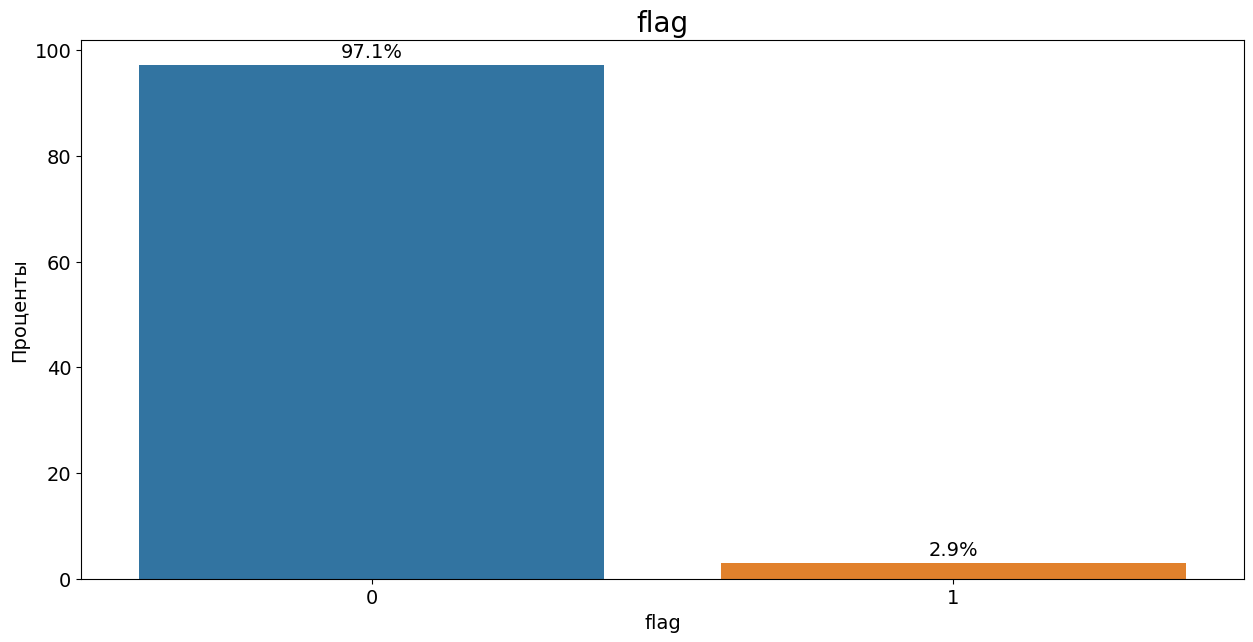

In [16]:
get_bins_target(df, "flag")

In [14]:
df_zeros = pd.DataFrame(index=range(250000), 
                        columns=db.columns, 
                        data=np.zeros((250000, db.shape[1])))
df_zeros.update(db.groupby(level=0).nth(-2))

df = df.join(df_zeros, rsuffix='_2')

In [15]:
df_zeros = pd.DataFrame(index=range(250000), 
                        columns=db.columns, 
                        data=np.zeros((250000, db.shape[1])))
df_zeros.update(db.groupby(level=0).nth(-3))

df = df.join(df_zeros, rsuffix='_3')

In [16]:
df_zeros = pd.DataFrame(index=range(250000), 
                        columns=db.columns, 
                        data=np.zeros((250000, db.shape[1])))
df_zeros.update(db.groupby(level=0).nth(-4))

df = df.join(df_zeros, rsuffix='_4')

In [30]:
df_zeros = pd.DataFrame(index=range(250000), 
                        columns=db.columns, 
                        data=np.zeros((250000, db.shape[1])))
df_zeros.update(db.groupby(level=0).nth(-5))

df = df.join(df_zeros, rsuffix='_5')

In [17]:
df[:5]

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_21_4,enc_paym_22_4,enc_paym_23_4,enc_paym_24_4,enc_loans_account_holder_type_4,enc_loans_credit_status_4,enc_loans_credit_type_4,enc_loans_account_cur_4,pclose_flag_4,fclose_flag_4
id,,,,,,,,,,,,,,,,,,,,,
0,10,7,9,2,10,8,8,16,4,2,...,3.0,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0
1,14,12,6,1,8,14,11,11,2,3,...,3.0,3.0,3.0,4.0,1.0,2.0,4.0,1.0,0.0,0.0
2,3,12,9,4,8,1,11,1,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,12,9,2,10,8,8,17,1,2,...,3.0,3.0,3.0,4.0,1.0,2.0,1.0,1.0,0.0,1.0
4,1,12,9,4,8,1,11,12,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
X = df.drop(['flag'], axis=1)
Y = df['flag']

In [32]:
X[:5]

,rn,pre_since_opened,pre_since_confirmed,pre_pterm,pre_fterm,pre_till_pclose,pre_till_fclose,pre_loans_credit_limit,pre_loans_next_pay_summ,pre_loans_outstanding,...,enc_paym_21_5,enc_paym_22_5,enc_paym_23_5,enc_paym_24_5,enc_loans_account_holder_type_5,enc_loans_credit_status_5,enc_loans_credit_type_5,enc_loans_account_cur_5,pclose_flag_5,fclose_flag_5
id,,,,,,,,,,,,,,,,,,,,,
0,10,7,9,2,10,8,8,16,4,2,...,3.0,3.0,3.0,4.0,1.0,2.0,3.0,1.0,0.0,1.0
1,14,12,6,1,8,14,11,11,2,3,...,0.0,0.0,0.0,1.0,1.0,2.0,3.0,1.0,0.0,0.0
2,3,12,9,4,8,1,11,1,1,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,15,12,9,2,10,8,8,17,1,2,...,3.0,3.0,3.0,4.0,1.0,3.0,4.0,1.0,0.0,0.0
4,1,12,9,4,8,1,11,12,1,3,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [38]:
pca = PCA(n_components=0.95, random_state=42)
embeding = pca.fit_transform(X)

In [39]:
embeding.shape

(250000, 55)

In [21]:
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [22]:
print(X.shape)

(250000, 237)


In [33]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                    test_size=0.2, 
                                                    stratify=Y, 
                                                    random_state=42)

In [40]:
model = LGBMClassifier(class_weight='balanced', random_state=42)
model.fit(x_train, y_train)

LGBMClassifier(class_weight='balanced', random_state=42)

In [41]:
y_pred_tr = model.predict(x_train)
y_score_tr = model.predict_proba(x_train)

y_pred = model.predict(x_test)
y_score = model.predict_proba(x_test)

In [42]:
res = get_metrics(y_train, y_pred_tr, y_score_tr, name="lgbm_train")
res = res.append(get_metrics(y_test, y_pred, y_score, name="lgbm_test"))

/tmp/ipykernel_13579/158785131.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_test, y_pred, y_score, name="lgbm_test"))


In [43]:
res

,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,lgbm_train,0.74321,0.853913,0.090583,0.807661,0.162896,0.509146
0,lgbm_test,0.73360,0.749237,0.071174,0.631545,0.127930,0.522715


In [63]:
model = RandomForestClassifier(class_weight='balanced', random_state=RAND)
model.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [64]:
y_pred_tr = model.predict(x_train)
y_score_tr = model.predict_proba(x_train)

y_pred = model.predict(x_test)
y_score = model.predict_proba(x_test)

In [65]:
res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, "RF_tr"))
res = res.append(get_metrics(y_test, y_pred, y_score, "RF_t"))
res

/tmp/ipykernel_29369/125579541.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, "RF_tr"))
/tmp/ipykernel_29369/125579541.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_test, y_pred, y_score, "RF_t"))


,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,lgbm_test,0.698860,0.714345,0.061022,0.606981,0.110895,0.571906
0,RF_tr,0.995855,0.998515,0.884141,0.996606,0.937011,0.028075
0,RF_t,0.964740,0.642046,0.102941,0.018100,0.030786,0.334651


In [68]:
model = LogisticRegression(class_weight='balanced', random_state=RAND)
model.fit(x_train, y_train)

/home/sergey/virtual_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', random_state=42)

In [69]:
y_pred_tr = model.predict(x_train)
y_score_tr = model.predict_proba(x_train)

y_pred = model.predict(x_test)
y_score = model.predict_proba(x_test)

In [70]:
res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, "LG_tr"))
res = res.append(get_metrics(y_test, y_pred, y_score, "LG_t"))
res

/tmp/ipykernel_29369/638020818.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_train, y_pred_tr, y_score_tr, "LG_tr"))
/tmp/ipykernel_29369/638020818.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(get_metrics(y_test, y_pred, y_score, "LG_t"))


,model,Accuracy,ROC_AUC,Precision,Recall,f1,Logloss
0,lgbm_test,0.698860,0.714345,0.061022,0.606981,0.110895,0.571906
0,RF_tr,0.995855,0.998515,0.884141,0.996606,0.937011,0.028075
0,RF_t,0.964740,0.642046,0.102941,0.018100,0.030786,0.334651
0,LG_tr,0.618685,0.683629,0.051393,0.648780,0.095241,0.642123
0,LG_t,0.617680,0.680340,0.051239,0.648352,0.094972,0.642936
